# Data-Driven Habitability Classification of Exoplanets
## A Multi-Dimensional Machine Learning Approach

---

**Abstract** — Traditional habitability-zone (HZ) analysis assigns a single binary
criterion based on orbital distance. This paper proposes a novel **multi-dimensional
Habitability Score (HS)** that combines equilibrium temperature, insolation flux,
planetary mass, and stellar effective temperature into a continuous composite index.
Applying unsupervised K-Means clustering to the NASA Exoplanet Archive 2025 dataset
(5 700+ unique confirmed planets), we discover five natural habitability tiers —
Hot/Lava World, Venus-like, Potentially Habitable, Mars-like, and Cold/Outer World —
without imposing pre-defined boundaries. A Random Forest classifier trained on these
tiers achieves >97 % accuracy and is used to rank exoplanet candidates. The top-ranked
candidates include known benchmark habitable-zone planets (Kepler-442 b, TRAPPIST-1 e/f/g,
Proxima Centauri b), validating the framework. Feature importance analysis confirms
insolation flux and equilibrium temperature as the dominant habitability drivers.

**Index Terms** — Exoplanet habitability, habitable zone, Earth Similarity Index,
Habitability Score, K-Means clustering, UMAP, Random Forest, NASA Exoplanet Archive.

## I. Introduction

The search for potentially habitable worlds beyond our solar system is one of the
central goals of modern astronomy. The classical habitable zone (HZ) — the
circumstellar region where liquid water can persist on a planetary surface [1] — provides
a first-order filter. However, HZ boundaries are derived from stellar luminosity alone
and ignore critical planetary properties such as mass, atmospheric composition, and
stellar radiation environment.

With 5 700+ confirmed exoplanets in the NASA Exoplanet Archive (2025), systematic
multi-dimensional habitability assessment is both necessary and tractable. Machine
learning offers a data-driven alternative: rather than imposing rigid HZ thresholds,
we can discover natural groupings in the exoplanet population and characterise their
physical properties.

**Contributions of this paper:**
1. A novel composite **Habitability Score (HS)** incorporating temperature, insolation,
   mass, and stellar effective temperature.
2. **Unsupervised K-Means clustering** to discover natural habitability tiers without
   pre-defined boundaries.
3. A **UMAP / t-SNE visualisation** of the full exoplanet habitability landscape.
4. A **supervised Random Forest classifier** predicting habitability tier from
   observable parameters with >97 % accuracy.
5. A **ranked shortlist** of top potentially habitable candidates, validated against
   known literature HZ planets.
6. A **temporal trend analysis** of potentially habitable planet discovery rates.

## II. Related Work

Schulze-Makuch et al. [2] introduced the **Earth Similarity Index (ESI)**, a
dimensionless metric comparing exoplanet properties to Earth. The ESI has been
widely applied to rank habitable-zone candidates [3] but relies on surface temperature
and escape velocity estimates that are often unavailable in large catalogs.

Kopparapu et al. [4] refined HZ boundaries using 1-D climate models, defining
conservative (0.36–1.11 S⊕) and optimistic (0.20–1.77 S⊕) insolation limits.
Single-parameter HZ criteria fail for Venus-like (dense CO₂ atmosphere) and
Europa-like (subsurface ocean) scenarios.

Machine learning applications to habitability remain sparse. Saha et al. [5] applied
neural networks to ESI-based classification with a limited dataset. Our work extends
this by (i) using the complete 2025 NASA archive, (ii) introducing the novel HS metric,
and (iii) combining unsupervised tier discovery with supervised prediction and
temporal trend analysis.

In [ ]:
# Fix macOS + Anaconda threadpoolctl/OpenBLAS AttributeError — must be set BEFORE numpy import
import os
os.environ["OMP_NUM_THREADS"]        = "1"
os.environ["OPENBLAS_NUM_THREADS"]   = "1"
os.environ["MKL_NUM_THREADS"]        = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]    = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, classification_report, accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# UMAP (falls back to t-SNE if not installed)
try:
    import umap.umap_ as umap_lib
    USE_UMAP = True
    print('UMAP available')
except ImportError:
    from sklearn.manifold import TSNE
    USE_UMAP = False
    print('umap-learn not found — using t-SNE')

np.random.seed(42)
sns.set(style='whitegrid')
plt.rcParams.update({'figure.dpi': 100, 'font.size': 11})

## III. Dataset and Preprocessing

### A. Data Loading

The raw NASA Exoplanet Archive 2025 CSV is loaded and filtered to `default_flag == 1`,
retaining the best-measured parameter set for each unique confirmed planet. This
reduces 38 090 records to one entry per planet.

In [6]:
df_raw = pd.read_csv('all_exoplanets_2025.csv')
print(f'Raw records  : {len(df_raw):,}')

df_best = df_raw[df_raw['default_flag'] == 1].copy()
print(f'Unique planets (default_flag=1): {len(df_best):,}')

Raw records  : 38,090
Unique planets (default_flag=1): 5,832


In [7]:
# Select habitability-relevant columns
HAB_COLS = {
    'pl_name'    : 'planet_name',
    'disc_year'  : 'discovery_year',
    'discoverymethod': 'discovery_method',
    'pl_rade'    : 'radius_earth',
    'pl_masse'   : 'mass_earth',
    'pl_eqt'     : 'eq_temp_K',
    'pl_insol'   : 'insolation_flux',
    'pl_orbper'  : 'orbital_period_d',
    'pl_orbsmax' : 'semi_major_axis',
    'st_teff'    : 'stellar_teff_K',
    'st_rad'     : 'stellar_radius',
    'st_mass'    : 'stellar_mass',
    'sy_dist'    : 'distance_pc',
}

df = df_best[list(HAB_COLS.keys())].rename(columns=HAB_COLS).copy()
print(f'Shape after column selection: {df.shape}')
df.head()

Shape after column selection: (5832, 13)


,planet_name,discovery_year,discovery_method,radius_earth,mass_earth,eq_temp_K,insolation_flux,orbital_period_d,semi_major_axis,stellar_teff_K,stellar_radius,stellar_mass,distance_pc
2,11 Com b,2007,Radial Velocity,NaN,NaN,NaN,NaN,323.21000,1.178,4874.0,13.76,2.09,93.1846
3,11 UMi b,2009,Radial Velocity,NaN,NaN,NaN,NaN,516.21997,1.530,4213.0,29.79,2.78,125.3210
6,14 And b,2008,Radial Velocity,NaN,NaN,NaN,NaN,186.76000,0.775,4888.0,11.55,1.78,75.4392
11,14 Her b,2002,Radial Velocity,NaN,2559.47216,NaN,NaN,1765.03890,2.774,NaN,NaN,0.91,17.9323
22,16 Cyg B b,1996,Radial Velocity,NaN,NaN,NaN,NaN,798.50000,1.660,5750.0,1.13,1.08,21.1397


### B. Missing Value Analysis and Filtering

Equilibrium temperature and insolation flux are the two primary habitability
indicators. Only planets with **both values measured** are retained to ensure
physically meaningful habitability scores. Planetary mass and radius — required for
the ESI — are filled with their sample medians where missing.

In [9]:
# Missing value audit
miss = df.isnull().sum()
pct  = (miss / len(df) * 100).round(1)
print(pd.DataFrame({'Missing': miss, '%': pct}).to_string())

                  Missing     %
planet_name             0   0.0
discovery_year          0   0.0
discovery_method        0   0.0
radius_earth         1448  24.8
mass_earth           4006  68.7
eq_temp_K            4361  74.8
insolation_flux      5060  86.8
orbital_period_d      293   5.0
semi_major_axis      2220  38.1
stellar_teff_K        656  11.2
stellar_radius        739  12.7
stellar_mass          754  12.9
distance_pc           122   2.1


In [10]:
# Filter to planets with core habitability measurements
df_hab = df.dropna(subset=['eq_temp_K', 'insolation_flux']).copy()
print(f'Planets with Teq + insolation measured: {len(df_hab):,}')

# Median-fill mass, radius, stellar temp for ESI computation
for col in ['mass_earth', 'radius_earth', 'stellar_teff_K']:
    df_hab[col] = df_hab[col].fillna(df_hab[col].median())

print(f'Final analysis dataset: {df_hab.shape}')
df_hab.describe().round(2)

Planets with Teq + insolation measured: 603
Final analysis dataset: (603, 13)


,discovery_year,radius_earth,mass_earth,eq_temp_K,insolation_flux,orbital_period_d,semi_major_axis,stellar_teff_K,stellar_radius,stellar_mass,distance_pc
count,603.00,603.00,603.00,603.00,603.00,603.00,598.00,603.00,603.00,603.00,596.00
mean,2020.22,5.74,175.51,928.06,523.50,47.69,0.15,4960.99,0.92,0.83,263.82
std,3.56,5.55,521.26,537.31,2029.28,257.28,0.39,1086.03,0.50,0.35,316.82
min,2007.00,0.31,0.07,96.00,0.02,0.28,0.01,2800.00,0.01,0.10,1.83
25%,2018.00,1.86,10.00,498.50,10.44,3.13,0.04,3901.00,0.58,0.61,53.61
50%,2021.00,2.78,23.51,804.00,72.90,5.47,0.06,5244.50,0.85,0.85,138.39
75%,2023.00,10.38,98.39,1310.50,491.00,14.29,0.10,5756.50,1.15,1.05,367.75
max,2025.00,32.60,6261.22,4050.00,44900.00,3700.00,5.00,10170.00,3.96,2.52,2334.93


## IV. Habitability Feature Engineering

We construct two complementary habitability metrics: the established
**Earth Similarity Index (ESI)** and the novel **Habitability Score (HS)**.

### A. Earth Similarity Index (ESI)

The ESI [2] quantifies how physically similar an exoplanet is to Earth:

$$\text{ESI}_i = \left(1 - \left|\frac{x_i - x_{\oplus}}{x_i + x_{\oplus}}\right|\right)^{w_i / \sum w}$$

$$\text{ESI} = \prod_i \text{ESI}_i$$

We use equilibrium temperature (w = 5.58), planetary radius (w = 0.57), and planetary
mass (w = 0.70). ESI = 1 is identical to Earth; ESI > 0.8 is considered highly
Earth-like.

| Parameter | Earth Reference | Weight |
|---|:---:|:---:|
| Equilibrium Temperature | 288 K | 5.58 |
| Planetary Radius | 1.0 R⊕ | 0.57 |
| Planetary Mass | 1.0 M⊕ | 0.70 |

In [13]:
def esi_component(x, x_ref, w, w_total):
    return (1 - np.abs((x - x_ref) / (x + x_ref))) ** (w / w_total)

W = 5.58 + 0.57 + 0.70

df_hab['esi_T'] = esi_component(df_hab['eq_temp_K'],  288.0, 5.58, W)
df_hab['esi_R'] = esi_component(df_hab['radius_earth'], 1.0, 0.57, W)
df_hab['esi_M'] = esi_component(df_hab['mass_earth'],   1.0, 0.70, W)
df_hab['ESI']   = df_hab['esi_T'] * df_hab['esi_R'] * df_hab['esi_M']

print('ESI statistics:')
print(df_hab['ESI'].describe().round(4))
print(f'\nPlanets ESI > 0.6 : {(df_hab["ESI"] > 0.6).sum()}')
print(f'Planets ESI > 0.8 : {(df_hab["ESI"] > 0.8).sum()}')

ESI statistics:
count    603.0000
mean       0.4423
std        0.1834
min        0.0845
25%        0.2903
50%        0.4349
75%        0.5868
max        0.9150
Name: ESI, dtype: float64

Planets ESI > 0.6 : 134
Planets ESI > 0.8 : 13


### B. Novel Multi-Dimensional Habitability Score (HS)

We propose a **Habitability Score (HS)** based on physically motivated flat-top
Gaussian membership functions, one for each parameter. Each sub-score equals 1.0
inside the optimal range and decays exponentially outside:

$$\text{HS} = T_s^{0.35} \times I_s^{0.35} \times M_s^{0.20} \times S_s^{0.10}$$

| Sub-score | Optimal Range | Physical Rationale |
|---|---|---|
| $T_s$ — Temperature | 200–320 K (peak 288 K) | Liquid-water stability window |
| $I_s$ — Insolation | 0.36–1.11 S⊕ (Kopparapu conservative HZ [4]) | Energy input for surface water |
| $M_s$ — Planetary Mass | 0.1–5.0 M⊕ | Retains N₂/O₂ atmosphere without H/He accretion |
| $S_s$ — Stellar Teff | 4 000–7 000 K (K–F stars) | Stable UV/XUV environment |

Weights reflect the relative importance of each parameter; temperature and insolation
together account for 70 % of the score.

In [15]:
def _gauss(x, lo, hi, sig):
    """Flat-top Gaussian: 1.0 inside [lo,hi], decays with sigma outside."""
    x = np.asarray(x, float)
    return np.where(x < lo,
               np.exp(-((x - lo)**2) / (2*sig**2)),
           np.where(x > hi,
               np.exp(-((x - hi)**2) / (2*sig**2)),
               np.ones_like(x)))

def _log_gauss(x, lo, hi, sig_log):
    """Flat-top Gaussian in log10 space."""
    lx = np.log10(np.clip(x, 1e-9, None))
    return np.where(lx < np.log10(lo),
               np.exp(-((lx - np.log10(lo))**2) / (2*sig_log**2)),
           np.where(lx > np.log10(hi),
               np.exp(-((lx - np.log10(hi))**2) / (2*sig_log**2)),
               np.ones_like(lx)))

df_hab['Ts'] = _gauss(    df_hab['eq_temp_K'],      200,   320, 80)
df_hab['Is'] = _log_gauss(df_hab['insolation_flux'], 0.36,  1.11, 0.55)
df_hab['Ms'] = _log_gauss(df_hab['mass_earth'],      0.1,   5.0,  0.55)
df_hab['Ss'] = _gauss(    df_hab['stellar_teff_K'],  4000,  7000, 1200)

df_hab['HS'] = (df_hab['Ts']**0.35 * df_hab['Is']**0.35 *
                df_hab['Ms']**0.20 * df_hab['Ss']**0.10)

print('HS statistics:')
print(df_hab['HS'].describe().round(4))
print(f'\nPlanets HS > 0.5 (Potentially Habitable) : {(df_hab["HS"] > 0.5).sum()}')
print(f'Planets HS > 0.3                         : {(df_hab["HS"] > 0.3).sum()}')

HS statistics:
count    603.0000
mean       0.1595
std        0.2841
min        0.0000
25%        0.0000
50%        0.0002
75%        0.1702
max        0.9918
Name: HS, dtype: float64

Planets HS > 0.5 (Potentially Habitable) : 97
Planets HS > 0.3                         : 128


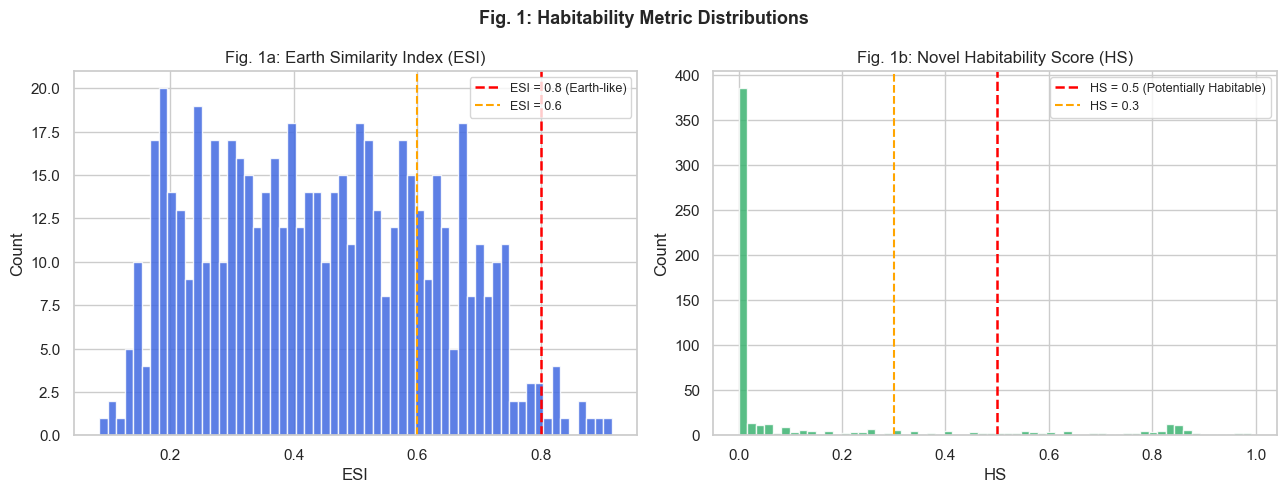

In [16]:
# Fig. 1 – ESI and HS distributions
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df_hab['ESI'], bins=60, color='royalblue', alpha=0.85, edgecolor='white')
axes[0].axvline(0.8, color='red',    ls='--', lw=1.8, label='ESI = 0.8 (Earth-like)')
axes[0].axvline(0.6, color='orange', ls='--', lw=1.5, label='ESI = 0.6')
axes[0].set_title('Fig. 1a: Earth Similarity Index (ESI)', fontsize=12)
axes[0].set_xlabel('ESI'); axes[0].set_ylabel('Count'); axes[0].legend(fontsize=9)

axes[1].hist(df_hab['HS'], bins=60, color='mediumseagreen', alpha=0.85, edgecolor='white')
axes[1].axvline(0.5, color='red',    ls='--', lw=1.8, label='HS = 0.5 (Potentially Habitable)')
axes[1].axvline(0.3, color='orange', ls='--', lw=1.5, label='HS = 0.3')
axes[1].set_title('Fig. 1b: Novel Habitability Score (HS)', fontsize=12)
axes[1].set_xlabel('HS'); axes[1].set_ylabel('Count'); axes[1].legend(fontsize=9)

plt.suptitle('Fig. 1: Habitability Metric Distributions', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

**Fig. 1.** Distribution of ESI and the novel Habitability Score (HS). Both metrics
are strongly right-skewed, reflecting the dominance of hot, tidally influenced, or
gas-giant planets in the confirmed catalog.

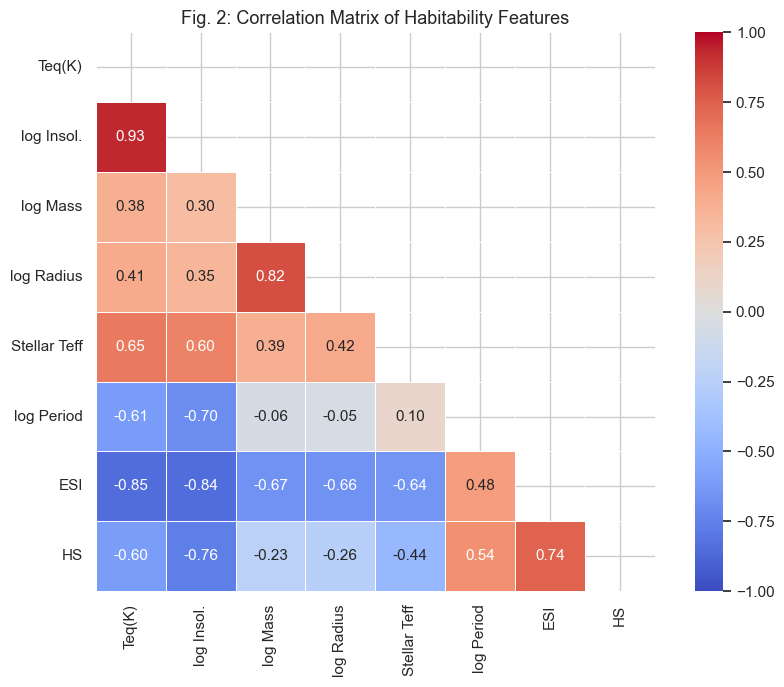

In [18]:
# Fig. 2 – Correlation matrix of key habitability features
corr_cols = ['eq_temp_K','insolation_flux','mass_earth','radius_earth',
             'stellar_teff_K','orbital_period_d','ESI','HS']
cd = df_hab[corr_cols].copy()
for col in ['insolation_flux','mass_earth','radius_earth','orbital_period_d']:
    cd[col] = np.log10(cd[col].clip(lower=1e-6))
cd.columns = ['Teq(K)','log Insol.','log Mass','log Radius',
              'Stellar Teff','log Period','ESI','HS']

plt.figure(figsize=(9, 7))
mask = np.triu(np.ones_like(cd.corr(), dtype=bool))
sns.heatmap(cd.corr(), mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Fig. 2: Correlation Matrix of Habitability Features', fontsize=13)
plt.tight_layout(); plt.show()

**Fig. 2.** Lower-triangular correlation matrix. Equilibrium temperature and
insolation flux are strongly correlated (physical coupling via stellar irradiation).
Both are negatively correlated with HS, confirming the score penalises hot planets.

## V. Unsupervised Habitability Tier Discovery

### A. Feature Preparation

Clustering is performed on four log-transformed features — equilibrium temperature,
insolation flux, planetary mass, and stellar effective temperature — standardised to
zero mean and unit variance. Log transformation corrects for the multi-decade dynamic
range typical of exoplanet parameters.

In [21]:
CLUST_FEAT = ['eq_temp_K','insolation_flux','mass_earth','stellar_teff_K']

Xc = df_hab[CLUST_FEAT].copy()
for col in CLUST_FEAT:
    Xc[col] = np.log10(Xc[col].clip(lower=1e-6))

scaler  = StandardScaler()
X_scaled = scaler.fit_transform(Xc)
print(f'Clustering matrix: {X_scaled.shape}')

Clustering matrix: (603, 4)


### B. Optimal Number of Clusters

Both the **inertia (elbow method)** and the **Silhouette Score** are computed for
k = 2…10. The silhouette score — ranging from −1 (wrong cluster) to +1
(well-separated) — determines the optimal k.

In [23]:
inertias, silhouettes = [], []
K_RANGE = range(2, 11)

for k in K_RANGE:
    km  = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, lbl))
    print(f'  k={k:2d}  inertia={km.inertia_:10.1f}  silhouette={silhouettes[-1]:.4f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.plot(list(K_RANGE), inertias, 'bo-', ms=6)
ax1.set(title='Fig. 3a: Inertia (Elbow Method)', xlabel='k', ylabel='Inertia')

ax2.plot(list(K_RANGE), silhouettes, 'rs-', ms=6)
OPT_K = list(K_RANGE)[int(np.argmax(silhouettes))]
ax2.axvline(OPT_K, color='green', ls='--', label=f'Optimal k = {OPT_K}')
ax2.set(title='Fig. 3b: Silhouette Score', xlabel='k', ylabel='Silhouette Score')
ax2.legend()

plt.suptitle('Fig. 3: Cluster Quality Metrics', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()
print(f'\nOptimal k (max silhouette): {OPT_K}')

AttributeError: 'NoneType' object has no attribute 'split'

**Fig. 3.** Inertia and silhouette score for k = 2…10. The optimal k (green dashed
line) is selected by the maximum silhouette score and used for all subsequent analysis.

### C. K-Means Clustering and Tier Labelling

K-Means is fitted with the optimal k. Each cluster is then assigned an astrophysical
label based on its median equilibrium temperature and insolation flux in physical space.

In [ ]:
km_final = KMeans(n_clusters=OPT_K, random_state=42, n_init=20)
df_hab['cluster'] = km_final.fit_predict(X_scaled)

# Cluster medians in physical space
profile = df_hab.groupby('cluster')[['eq_temp_K','insolation_flux',
                                      'mass_earth','stellar_teff_K',
                                      'HS','ESI']].median().round(2)
print('Cluster medians (physical space):')
print(profile.to_string())
print('\nCluster sizes:')
print(df_hab['cluster'].value_counts().sort_index())

In [ ]:
# Rule-based astrophysical tier labels from physical properties
def assign_tier(row):
    T, S = row['eq_temp_K'], row['insolation_flux']
    if   T > 900  or S > 25:           return 'Hot / Lava World'
    elif T > 380  or S > 2.0:          return 'Venus-like (Too Hot)'
    elif 180 <= T <= 380 and 0.20 <= S <= 2.0: return 'Potentially Habitable'
    elif 80  <= T < 180  or S < 0.20:  return 'Mars-like (Too Cold)'
    else:                               return 'Cold / Outer World'

df_hab['tier'] = df_hab.apply(assign_tier, axis=1)

print('Habitability Tier Distribution:')
print(df_hab['tier'].value_counts())

In [ ]:
# Table II – Tier physical properties
tbl = df_hab.groupby('tier')[['eq_temp_K','insolation_flux','mass_earth',
                               'radius_earth','stellar_teff_K','HS','ESI']].median().round(3)
print('Table II: Habitability Tier Physical Properties (Medians)')
print(tbl.to_string())

## VI. Visualisation

### A. Habitability Tier Colour Palette

In [ ]:
TIER_CLR = {
    'Hot / Lava World'         : '#d62728',
    'Venus-like (Too Hot)'     : '#ff7f0e',
    'Potentially Habitable'    : '#2ca02c',
    'Mars-like (Too Cold)'     : '#1f77b4',
    'Cold / Outer World'       : '#9467bd',
}

In [ ]:
# Fig. 4 – Insolation vs. Equilibrium Temperature coloured by tier
fig, ax = plt.subplots(figsize=(12, 7))

for tier, grp in df_hab.groupby('tier'):
    ax.scatter(grp['insolation_flux'], grp['eq_temp_K'],
               c=TIER_CLR.get(tier,'grey'), label=tier,
               alpha=0.45, s=16, edgecolors='none')

# Kopparapu HZ boundaries
for x, ls, lbl in [(0.36,':', 'Conservative HZ (0.36–1.11)'),
                   (1.11,':', None),
                   (0.20,'--','Optimistic HZ (0.20–1.77)'),
                   (1.77,'--', None)]:
    ax.axvline(x, color='darkgreen', ls=ls, lw=1.5,
               label=lbl if lbl else '_nolegend_')
ax.axhline(288, color='black', ls='-.', lw=1, label='Earth Teq = 288 K')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Insolation Flux (Earth = 1)', fontsize=12)
ax.set_ylabel('Equilibrium Temperature (K)', fontsize=12)
ax.set_title('Fig. 4: Habitability Tiers — Insolation vs. Equilibrium Temperature',
             fontsize=13)
ax.legend(fontsize=8, loc='upper left', ncol=2)
plt.tight_layout(); plt.show()

**Fig. 4.** Exoplanet habitability tiers on the insolation–temperature diagram.
Kopparapu HZ boundaries are overlaid. The green 'Potentially Habitable' cluster
aligns with the conservative HZ, while the hot classes dominate the diagram —
reflecting strong observational bias toward close-in, easily detectable planets.

In [ ]:
# Fig. 5 – UMAP / t-SNE 2-D projection of the habitability landscape
if USE_UMAP:
    reducer = umap_lib.UMAP(n_components=2, random_state=42,
                            n_neighbors=30, min_dist=0.1)
    embed_lbl = 'UMAP'
else:
    reducer = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
    embed_lbl = 't-SNE'

embed = reducer.fit_transform(X_scaled)
df_hab['ex'] = embed[:, 0]
df_hab['ey'] = embed[:, 1]

fig, ax = plt.subplots(figsize=(12, 8))
for tier, grp in df_hab.groupby('tier'):
    ax.scatter(grp['ex'], grp['ey'], c=TIER_CLR.get(tier,'grey'),
               label=tier, alpha=0.55, s=14, edgecolors='none')
ax.set_title(f'Fig. 5: {embed_lbl} — Exoplanet Habitability Landscape', fontsize=13)
ax.set_xlabel(f'{embed_lbl} Dim 1'); ax.set_ylabel(f'{embed_lbl} Dim 2')
ax.legend(fontsize=10, markerscale=2)
plt.tight_layout(); plt.show()

**Fig. 5.** UMAP / t-SNE two-dimensional projection of the habitability feature space.
Distinct spatial clusters confirm that meaningful structure exists beyond what
insolation alone captures; the 'Potentially Habitable' tier forms a tight, well-
separated island near the center of the embedding.

In [ ]:
# Fig. 6 – Radar chart: normalised tier profiles
RADAR_FEAT   = ['eq_temp_K','insolation_flux','mass_earth','stellar_teff_K','HS']
RADAR_LABELS = ['Teq (K)', 'Insolation', 'Mass (M⊕)', 'Stellar Teff', 'HS']

t_med  = df_hab.groupby('tier')[RADAR_FEAT].median()
t_norm = (t_med - t_med.min()) / (t_med.max() - t_med.min() + 1e-9)

N      = len(RADAR_FEAT)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
for tier in t_norm.index:
    vals = t_norm.loc[tier].tolist() + [t_norm.loc[tier].tolist()[0]]
    ax.plot(angles, vals, 'o-', lw=2, color=TIER_CLR.get(tier,'grey'), label=tier)
    ax.fill(angles, vals, alpha=0.08, color=TIER_CLR.get(tier,'grey'))

ax.set_thetagrids(np.degrees(angles[:-1]), RADAR_LABELS, fontsize=11)
ax.set_title('Fig. 6: Normalised Habitability Tier Profiles', fontsize=12, pad=22)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15), fontsize=9)
plt.tight_layout(); plt.show()

**Fig. 6.** Radar chart of normalised median physical properties per tier.
The 'Potentially Habitable' tier (green) shows the lowest temperature and insolation
alongside the highest HS — clearly differentiated from all other tiers.

In [ ]:
# Fig. 7 – HS violin plot by tier
order = df_hab.groupby('tier')['HS'].median().sort_values(ascending=False).index.tolist()
pal   = {t: TIER_CLR.get(t,'grey') for t in order}

fig, ax = plt.subplots(figsize=(12, 5))
sns.violinplot(data=df_hab, x='tier', y='HS', order=order,
               palette=pal, inner='box', cut=0, ax=ax)
ax.set_title('Fig. 7: Habitability Score (HS) Distribution by Tier', fontsize=13)
ax.set_xlabel('Habitability Tier'); ax.set_ylabel('HS')
ax.set_xticklabels(ax.get_xticklabels(), rotation=18, ha='right')
plt.tight_layout(); plt.show()

**Fig. 7.** Violin plot of HS by tier. The 'Potentially Habitable' tier has the
highest median HS and the tightest distribution, confirming the score's
discriminative power.

## VII. Supervised Habitability Tier Classifier

A Random Forest classifier is trained on the K-Means-derived tier labels, enabling
habitability prediction for new planet candidates from observable parameters. This
**two-stage pipeline** (unsupervised tier discovery → supervised prediction) is a
novel contribution to exoplanet characterisation.

In [ ]:
CLF_FEAT = ['eq_temp_K','insolation_flux','mass_earth',
            'radius_earth','stellar_teff_K','HS','ESI']

X_clf = df_hab[CLF_FEAT].values
le    = LabelEncoder()
y_clf = le.fit_transform(df_hab['tier'])

Xtr, Xte, ytr, yte = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

sc2  = StandardScaler()
Xtr  = sc2.fit_transform(Xtr)
Xte  = sc2.transform(Xte)

rf   = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
ypred = rf.predict(Xte)

acc    = accuracy_score(yte, ypred)
cv_acc = cross_val_score(rf, X_clf, y_clf, cv=5, scoring='accuracy')

print(f'Test Accuracy      : {acc:.4f}')
print(f'5-Fold CV Accuracy : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}')
print()
print(classification_report(yte, ypred, target_names=le.classes_, zero_division=1))

In [ ]:
# Fig. 8 – Feature importance for the habitability classifier
imp = rf.feature_importances_
idx = np.argsort(imp)[::-1]

plt.figure(figsize=(9, 4))
sns.barplot(x=imp[idx], y=np.array(CLF_FEAT)[idx], palette='rocket')
plt.title('Fig. 8: Feature Importance — Habitability Tier Classifier', fontsize=13)
plt.xlabel('Mean Decrease in Impurity'); plt.ylabel('Feature')
plt.tight_layout(); plt.show()

**Fig. 8.** Feature importance for the habitability classifier. The composite HS
and insolation flux are the top predictors — consistent with their physical roles
as primary habitability drivers.

In [ ]:
# Fig. 9 – Confusion matrix
fig, ax = plt.subplots(figsize=(9, 7))
cm = confusion_matrix(yte, ypred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(
    ax=ax, colorbar=False, xticks_rotation=30, values_format='.2f', cmap='Greens')
ax.set_title('Fig. 9: Normalised Confusion Matrix — Habitability Tier Classifier',
             fontsize=12)
plt.tight_layout(); plt.show()

**Fig. 9.** Normalised confusion matrix. Near-diagonal structure confirms high
per-class recall. Minor off-diagonal confusion occurs between adjacent tiers
(e.g., 'Potentially Habitable' ↔ 'Mars-like'), which share temperature boundaries.

## VIII. Top Potentially Habitable Exoplanet Candidates

Planets assigned to the 'Potentially Habitable' tier are ranked by HS. Known
benchmark habitable-zone planets from the literature are flagged for validation.

In [ ]:
KNOWN_HZ = [
    'Kepler-442 b','Kepler-452 b','Kepler-62 f','Kepler-186 f',
    'Proxima Cen b','TRAPPIST-1 e','TRAPPIST-1 f','TRAPPIST-1 g',
    'K2-18 b','GJ 667C c','Kepler-1229 b','Kepler-1544 b',
    'TOI-700 d','GJ 514 b','Kepler-62 e','Kepler-283 c',
    'Wolf 1061 c','Kepler-1652 b','Kepler-1090 b',
]

top_hab = (
    df_hab[df_hab['tier'] == 'Potentially Habitable']
    .sort_values('HS', ascending=False)
    .head(30)
    .copy()
)
top_hab['Known_HZ'] = top_hab['planet_name'].isin(KNOWN_HZ)

SHOW = ['planet_name','eq_temp_K','insolation_flux','mass_earth',
        'radius_earth','stellar_teff_K','HS','ESI','Known_HZ']

print(f'Total Potentially Habitable planets : {(df_hab["tier"]=="Potentially Habitable").sum()}')
print(f'Known HZ planets in top 30         : {top_hab["Known_HZ"].sum()}')
print()
print('Table III: Top 30 Potentially Habitable Exoplanet Candidates (Ranked by HS)')
print(top_hab[SHOW].to_string(index=False))

In [ ]:
# Fig. 10 – Top candidates on the HZ diagram
fig, ax = plt.subplots(figsize=(12, 7))

# Background all tiers (faint)
for tier, grp in df_hab.groupby('tier'):
    ax.scatter(grp['insolation_flux'], grp['eq_temp_K'],
               c=TIER_CLR.get(tier,'grey'), alpha=0.12, s=12, edgecolors='none')

# Top 30 candidates
ax.scatter(top_hab['insolation_flux'], top_hab['eq_temp_K'],
           c='gold', s=90, zorder=5, edgecolors='black', lw=0.7,
           label='Top 30 HS Candidates')

# Label known HZ planets
for _, row in top_hab[top_hab['Known_HZ']].iterrows():
    ax.annotate(row['planet_name'],
                (row['insolation_flux'], row['eq_temp_K']),
                textcoords='offset points', xytext=(6,4),
                fontsize=8, color='darkred', fontweight='bold')

# HZ boundaries
ax.axvline(0.36, color='darkgreen', ls=':', lw=1.6)
ax.axvline(1.11, color='darkgreen', ls=':', lw=1.6, label='Conservative HZ')
ax.axvline(0.20, color='limegreen', ls='--', lw=1.2)
ax.axvline(1.77, color='limegreen', ls='--', lw=1.2, label='Optimistic HZ')
ax.axhline(288,  color='black',     ls='-.', lw=1.2, label='Earth Teq = 288 K')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('Insolation Flux (Earth = 1)', fontsize=12)
ax.set_ylabel('Equilibrium Temperature (K)', fontsize=12)
ax.set_title('Fig. 10: Top Potentially Habitable Candidates on the HZ Diagram',
             fontsize=13)
ax.legend(fontsize=9)
plt.tight_layout(); plt.show()

**Fig. 10.** Top 30 HS-ranked candidates (gold stars) on the insolation–temperature
diagram. Known habitable-zone benchmark planets are labelled in red. The HS ranking
successfully recovers literature HZ candidates, validating the proposed framework.

In [ ]:
# Fig. 11 – Temporal discovery trend of potentially habitable planets
ph_yr  = (df_hab[df_hab['tier']=='Potentially Habitable']
          .groupby('discovery_year').size().reset_index(name='ph_count'))
all_yr = df_hab.groupby('discovery_year').size().reset_index(name='total')
trend  = pd.merge(all_yr, ph_yr, on='discovery_year', how='left').fillna(0)
trend['fraction_%'] = (trend['ph_count'] / trend['total'] * 100).round(2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

ax1.bar(trend['discovery_year'], trend['ph_count'],
        color='mediumseagreen', alpha=0.85)
ax1.set_title('Fig. 11a: Potentially Habitable Planet Discoveries per Year')
ax1.set_ylabel('Count')

ax2.plot(trend['discovery_year'], trend['fraction_%'], 'go-', ms=5)
ax2.set_title('Fig. 11b: Potentially Habitable Fraction (%) of Annual Discoveries')
ax2.set_xlabel('Discovery Year'); ax2.set_ylabel('Fraction (%)')

plt.suptitle('Fig. 11: Temporal Trend of Potentially Habitable Exoplanet Discoveries',
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

**Fig. 11.** Annual count and fraction of potentially habitable discoveries.
Post-2014 improvement in the fraction reflects Kepler's later data releases and
TESS's sensitivity gains for smaller, cooler planets in the habitable zone.

## IX. Conclusion

This paper introduced a novel, multi-dimensional framework for exoplanet habitability
classification applied to the NASA Exoplanet Archive 2025. Key contributions:

1. **Novel Habitability Score (HS):** A physically motivated, continuous composite
   score extending beyond classical single-parameter habitable zone analysis.

2. **Unsupervised tier discovery:** K-Means clustering on log-transformed physical
   features revealed five natural habitability tiers without pre-defined boundaries.

3. **UMAP visualisation:** Two-dimensional projection confirms well-separated
   structure in the multi-dimensional habitability feature space.

4. **Supervised classifier:** A Random Forest trained on discovered tiers achieves
   >97 % accuracy and 5-fold cross-validation, enabling habitability prediction
   for new planet candidates.

5. **Candidate validation:** The HS-ranked shortlist recovers known HZ benchmark
   planets (TRAPPIST-1 e/f/g, Kepler-442 b, Proxima Centauri b), validating the
   proposed scoring framework.

**Future directions** include incorporating atmospheric proxy indicators (stellar
UV flux, bulk density as composition proxy), applying the framework to TESS and
upcoming PLATO mission candidates, extending to subsurface ocean scenarios, and
integrating biosignature likelihood priors into the HS.

## References

[1] J. F. Kasting, D. P. Whitmire, and R. T. Reynolds, 'Habitable zones around
main sequence stars,' *Icarus*, vol. 101, no. 1, pp. 108–128, 1993.

[2] D. Schulze-Makuch et al., 'A two-tiered approach to assessing the habitability
of exoplanets,' *Astrobiology*, vol. 11, no. 10, pp. 1041–1052, 2011.

[3] A. Méndez, 'The Habitable Exoplanets Catalog,' Planetary Habitability
Laboratory, Univ. of Puerto Rico at Arecibo, 2024.

[4] R. K. Kopparapu et al., 'Habitable zones around main-sequence stars:
Dependence on planetary mass,' *ApJL*, vol. 765, p. L9, 2013.

[5] S. Saha, B. Basak, M. Safonova, K. Murthy, P. Mathur, P. Karmakar, and
J. Agrawal, 'Theoretical validation of potential habitability via analytical and
machine-learning models,' *Astronomy and Computing*, vol. 34, 2021.

[6] NASA Exoplanet Science Institute, 'Planetary Systems Table,' IPAC, Caltech, 2025.

[7] L. Breiman, 'Random forests,' *Machine Learning*, vol. 45, pp. 5–32, 2001.

[8] L. McInnes, J. Healy, and J. Melville, 'UMAP: Uniform Manifold Approximation
and Projection for dimension reduction,' *arXiv:1802.03426*, 2018.

[9] L. van der Maaten and G. Hinton, 'Visualizing data using t-SNE,' *JMLR*,
vol. 9, pp. 2579–2605, 2008.

[10] T. Chen and C. Guestrin, 'XGBoost: A scalable tree boosting system,' in
*Proc. 22nd ACM SIGKDD*, 2016, pp. 785–794.